# Epoch vs Accuracy Figures

This notebook plots the epoch vs accuracy figures, comparing NSIL to the baselines. For quick access to a particular experiment, please click on the corresponding link here:

| **Addition**  | **E9P** | **HS** | **CHS** |
| ----------- | ----------- | ----------- | ----------- |
| [100% Training Data](#mnist_addition_100_pct) | [100% Training Data](#mnist_alternative_hyp_100_pct) | [MNIST](#hitting_sets_mnist) | [MNIST](#hitting_sets_alternative_hyp_mnist) |
| [10% Training Data](#mnist_addition_10_pct) | [10% Training Data](#mnist_alternative_hyp_10_pct) | [FashionMNIST](#hitting_sets_fashion_mnist) | [FashionMNIST](#hitting_sets_alternative_hyp_mnist) |
| [5% Training Data](#mnist_addition_5_pct) | [5% Training Data](#mnist_alternative_hyp_5_pct) |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import json
from scipy.stats import sem
from os.path import join

In [2]:
# Helper functions
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [3]:
def plot(example_dir,
         baselines,
         save_name,
         dataset_pct=100,
         num_epochs=20,
         save_legend=False,
         dataset=None,
         y_lim=[-0.05, 1.05]):
    
    baseline_base_dir = example_dir+'/baselines/saved_results'
    nsl_repeats_dir = example_dir+'/saved_results'
    
    if dataset is not None:
        baseline_base_dir = baseline_base_dir+'/'+dataset
        nsl_no_corrective_ex_repeats_dir = nsl_repeats_dir+'/no_corrective_ex_repeats/'+dataset
        nsl_repeats_dir = nsl_repeats_dir+'/repeats/'+dataset
    else:
        nsl_no_corrective_ex_repeats_dir = nsl_repeats_dir+'/no_corrective_ex_repeats'
        nsl_repeats_dir = nsl_repeats_dir+'/repeats'
    
    # We plot mean accuracy per epoch alongside standard error of the mean
    # Get NSL results
    nsl_means = []
    nsl_errs = []
    nsl_dir = nsl_repeats_dir+'/'+str(dataset_pct)
    repeats = os.listdir(nsl_dir)
    repeats = [r for r in repeats if r != '.DS_Store']
    repeats.sort(key=natural_keys)
    
    # X data is just epoch number
    full_range = num_epochs + 1
    X = list(range(full_range))
    
    for epoch_num in range(full_range):
        all_results_epoch = []
        for idx, i in enumerate(repeats):
            # Read in test_log and get end-to-end accuracy at this epoch
            with open(join(nsl_dir, i, 'test_log.json'), 'r') as jf:
                tl = json.loads(jf.read())
                acc = tl[str(epoch_num)]['end_to_end_acc']
                all_results_epoch.append(acc)
            
        # Compute mean and std err across all repeats
        nsl_means.append(np.mean(all_results_epoch))
        nsl_errs.append(sem(all_results_epoch))
        
    # Get no corrective ex results
    nce_means = []
    nce_errs = []
    nce_dir = nsl_no_corrective_ex_repeats_dir+'/'+str(dataset_pct)
    nce_repeats = os.listdir(nce_dir)
    nce_repeats = [r for r in nce_repeats if r != '.DS_Store']
    nce_repeats.sort(key=natural_keys)
    
    # X data is just epoch number
    full_range = num_epochs + 1
    X = list(range(full_range))
    
    for epoch_num in range(full_range):
        all_results_epoch = []
        for idx, i in enumerate(nce_repeats):
            # Read in test_log and get end-to-end accuracy at this epoch
            with open(join(nce_dir, i, 'test_log.json'), 'r') as jf:
                tl = json.loads(jf.read())
                acc = tl[str(epoch_num)]['end_to_end_acc']
                all_results_epoch.append(acc)
            
        # Compute mean and std err across all repeats
        nce_means.append(np.mean(all_results_epoch))
        nce_errs.append(sem(all_results_epoch))
        
    # Get baseline results
    baseline_results = {}
    for b in baselines:
        baseline_results[b] = {
            "means": [], "errs": []
        }
        
        b_dir = baseline_base_dir+'/'+b+'/'+str(dataset_pct)
        b_repeats = os.listdir(b_dir)
        b_repeats = [b_r for b_r in b_repeats if b_r != '.DS_Store']
        b_repeats = [b_r for b_r in b_repeats if 'csv' not in b_r]
        b_repeats = [b_r for b_r in b_repeats if 'txt' not in b_r]
        b_repeats.sort(key=natural_keys)
        
        for epoch_num in range(full_range):
            all_b_results_epoch = []
            for idx, i in enumerate(b_repeats):
                # Read in test_log and get accuracy for this epoch
                if b == 'meta_abd':
                    b_tl = pd.read_csv(b_dir+'/'+i+'/test.csv')
                    if epoch_num in b_tl['task_accuracy']:
                        acc = b_tl['task_accuracy'][epoch_num]
                        all_b_results_epoch.append(acc)
                    else:
                        print(f'Warning: Epoch {epoch_num} not in Meta_Abd {dataset_pct}% repeat {i}')
                else:
                    b_tl = pd.read_csv(b_dir+'/'+i+'/test_log.csv')
                    acc = b_tl['accuracy'][epoch_num]
                    all_b_results_epoch.append(acc)
                
            # Calculate mean and stderr
            if len(all_b_results_epoch) > 0:
                baseline_results[b]['means'].append(np.mean(all_b_results_epoch))
                baseline_results[b]['errs'].append(sem(all_b_results_epoch))
            else:
                baseline_results[b]['means'].append(np.nan)
                baseline_results[b]['errs'].append(np.nan)
            
    # Plot graph
    figure_handles = []
    figure_labels = []
    fig = plt.figure("data figure")
    legend_fig = plt.figure("legend figure")
    ax = fig.add_subplot(111)
    nsl_plot, = ax.plot(X, nsl_means, color="k")
    figure_handles.append(nsl_plot)
    figure_labels.append('NSIL')
    ax.errorbar(X, nsl_means, nsl_errs, color="k", capsize=5)
    
    # No corrective examples
    nce_plot, = ax.plot(X, nce_means, color="k", linestyle=':')
    figure_handles.append(nce_plot)
    figure_labels.append('NSIL Without Corrective Examples')
    ax.errorbar(X, nce_means, nce_errs, color="k", linestyle=':', capsize=5)
    
    b_colours = ['b', 'g', 'r', 'm', 'c', 'tab:brown']
    b_lines = ["--","-.",":", ":", ":", ":"]
    markers = [None, None, None, "d", "x", "^"]
    for idx, b in enumerate(baselines):
        b_plot, = ax.plot(X, 
                 baseline_results[b]['means'], 
                 label='Baseline {0}'.format(baselines[b]), 
                 linestyle=b_lines[idx],
                 color=b_colours[idx],
                 marker=markers[idx])
        
        figure_handles.append(b_plot)
        figure_labels.append(baselines[b])
        
        ax.errorbar(X, 
                     baseline_results[b]['means'],
                     baseline_results[b]['errs'],
                     color=b_colours[idx],
                     linestyle=b_lines[idx],
                     capsize=5)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_xticks(X)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(which='both')
    ax.set_ylim(y_lim)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    
    base_dir = '../figures/epoch_vs_accuracy/'
    if save_legend:
        legend_fig.legend(figure_handles, figure_labels, loc='center', ncol=3)
        legend_fig.savefig(base_dir+save_name, bbox_inches='tight')
    else:
        fig.savefig(base_dir+save_name, bbox_inches='tight')

# Figures

## Addition

In [20]:
# Example directory
example_name = 'arithmetic'
dataset = 'sum'
example = '../../../examples/'+example_name

# Baseline ID with display name
baseline_info = {
    'cnn': 'CNN', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S',
    'cnn_lstm_nac': 'CNN-LSTM-NAC',
    'cnn_lstm_nalu': 'CNN-LSTM-NALU',
    'meta_abd': 'Meta_Abd'
}

### Legend
`%%capture` prevents the figure from showing inline

In [21]:
%%capture
plot(example, baseline_info, save_name='legend.pdf', save_legend=True, dataset=dataset)

<a id='mnist_addition_100_pct'></a>
### 100% Training Data

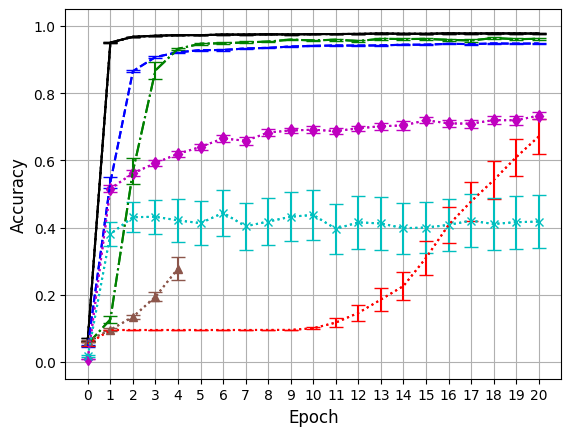

<Figure size 640x480 with 0 Axes>

In [12]:
plot(example, baseline_info, save_name=f'{example_name}_{dataset}_100_pct.pdf', dataset=dataset)

<a id='mnist_addition_10_pct'></a>
### 10% Training Data

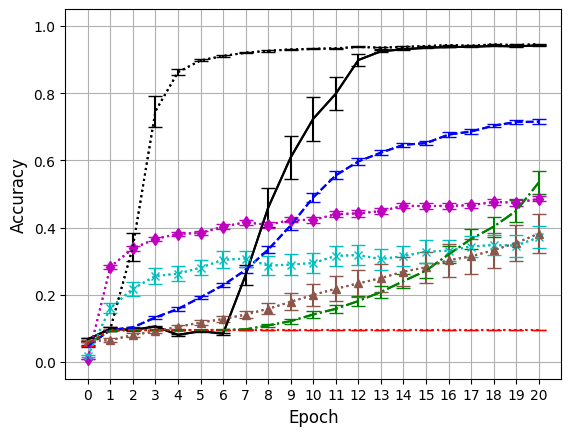

<Figure size 640x480 with 0 Axes>

In [13]:
plot(example, baseline_info, dataset_pct=10, save_name=f'{example_name}_{dataset}_10_pct.pdf', dataset=dataset)

<a id='mnist_addition_5_pct'></a>
### 5% Training Data

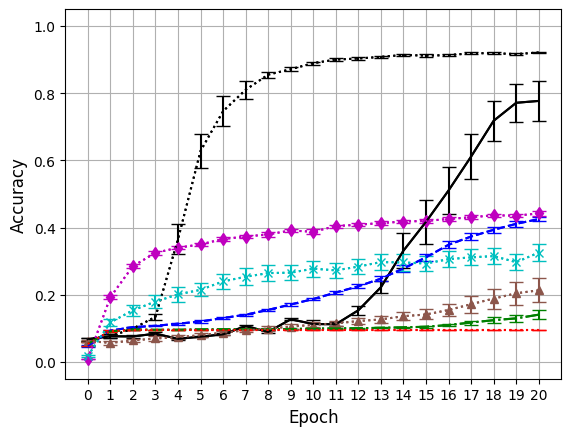

<Figure size 640x480 with 0 Axes>

In [14]:
plot(example, baseline_info, dataset_pct=5, save_name=f'{example_name}_{dataset}_5_pct.pdf', dataset=dataset)

## E9P

In [15]:
# Example directory
dataset = 'e9p'
baseline_info = {
    'cnn': 'CNN', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S',
    'cnn_lstm_nac': 'CNN-LSTM-NAC',
    'cnn_lstm_nalu': 'CNN-LSTM-NALU'
}

<a id='mnist_alternative_hyp_100_pct'></a>
### 100% Training Data

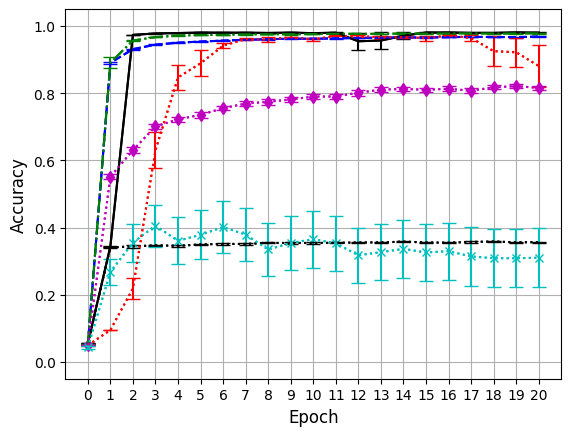

<Figure size 640x480 with 0 Axes>

In [16]:
plot(example, baseline_info, save_name=f'{example_name}_{dataset}_100_pct.pdf', dataset=dataset)

<a id='mnist_alternative_hyp_10_pct'></a>
### 10% Training Data 

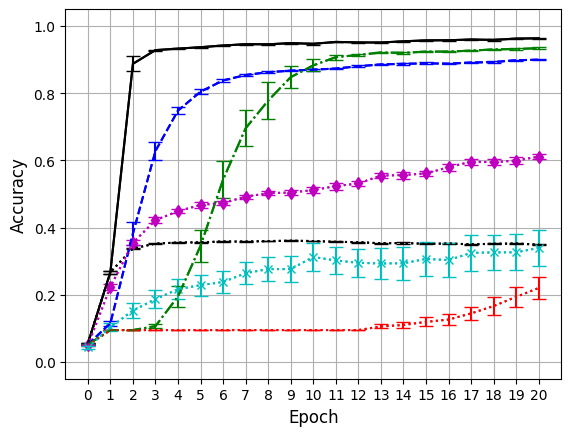

<Figure size 640x480 with 0 Axes>

In [17]:
plot(example, baseline_info, dataset_pct=10, save_name=f'{example_name}_{dataset}_10_pct.pdf', dataset=dataset)

<a id='mnist_alternative_hyp_5_pct'></a>
### 5% Training Data

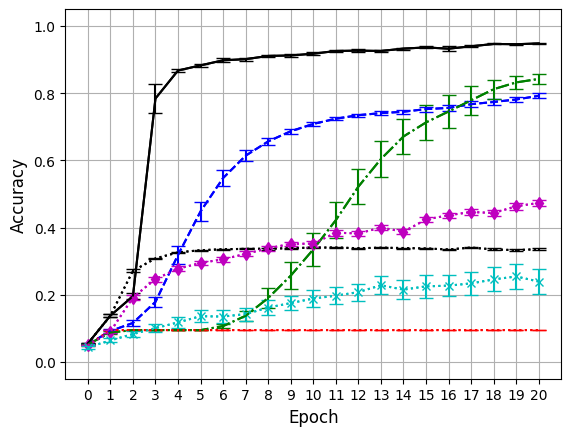

<Figure size 640x480 with 0 Axes>

In [18]:
plot(example, baseline_info, dataset_pct=5, save_name=f'{example_name}_{dataset}_5_pct.pdf', dataset=dataset)

## HS

In [4]:
# Example directory
example_name = 'hitting_sets'
example = '../../../examples/'+example_name

# Baseline ID with display name
baseline_info = {
    'cnn_lstm': 'CNN-LSTM', 
    'cbm_joint_lambda_0': 'CBM',
    'cbm_joint_lambda_0_with_softmax': 'CBM-S'
}

### Legend
`%%capture` prevents the figure from showing inline

In [5]:
%%capture
plot(example, baseline_info, save_name='hs_legend.pdf', save_legend=True, dataset='HS_mnist')

<a id='hitting_sets_mnist'></a>
### MNIST

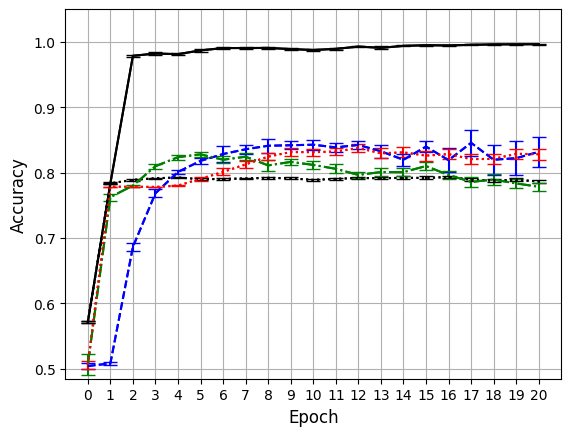

<Figure size 640x480 with 0 Axes>

In [7]:
plot(example, baseline_info, save_name=f'HS_mnist.pdf', dataset='HS_mnist', y_lim=[0.485, 1.05])

<a id='hitting_sets_fashion_mnist'></a>
### FashionMNIST

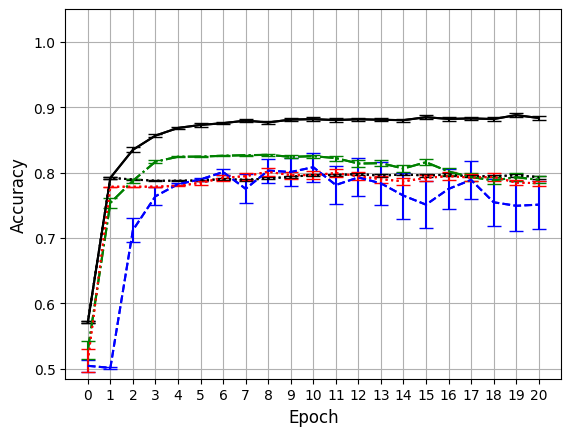

<Figure size 640x480 with 0 Axes>

In [8]:
plot(example, baseline_info, save_name=f'HS_fashion_mnist.pdf', dataset='HS_fashion_mnist', y_lim=[0.485, 1.05])

## CHS

<a id='hitting_sets_alternative_hyp_mnist'></a>
### MNIST

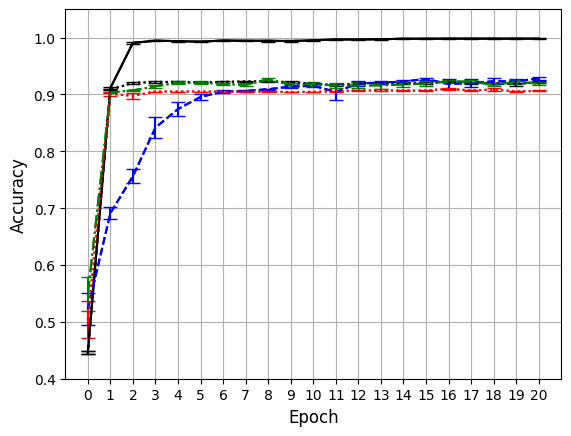

<Figure size 640x480 with 0 Axes>

In [28]:
plot(example, baseline_info, save_name=f'CHS_mnist.pdf', dataset='CHS_mnist', y_lim=[0.4, 1.05])

<a id='hitting_sets_alternative_hyp_fashion_mnist'></a>
### FashionMNIST

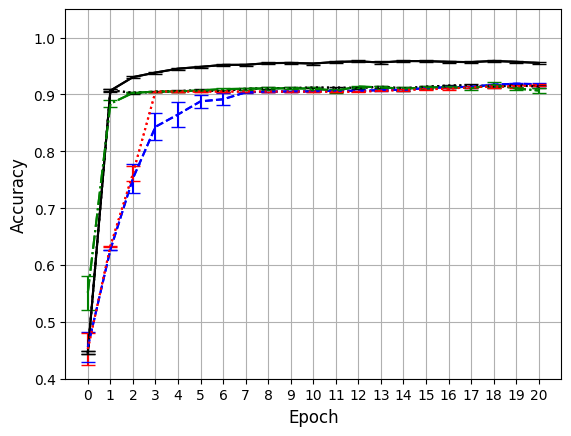

<Figure size 640x480 with 0 Axes>

In [29]:
plot(example, baseline_info, save_name=f'CHS_fashion_mnist.pdf', dataset='CHS_fashion_mnist', y_lim=[0.4, 1.05])